In [37]:
import cv2
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist

In [ ]:
(X_train,y_train),(X_test,y_test)=fashion_mnist.load_data()
X_train, X_test= X_train/255.0, X_test/255.0
print(f"X-train shape: {X_train.shape}")
print(f"y-train shape: {y_train.shape}")
print(f"X-test shape: {X_test.shape}")
print(f"y-test shape: {y_test.shape}")

X-train shape: (60000, 28, 28)
y-train shape: (60000,)
X-test shape: (10000, 28, 28)
y-test shape: (10000,)


In [ ]:
y_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
            'Sneaker','Bag','Ankle Boot']

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
# Flattening data for Logistic Regression
X_train_flatten= X_train.reshape(X_train.shape[0],-1)
y_train_flatten= y_train.reshape(y_train.shape[0],-1)
X_test_flatten= X_test.reshape(X_test.shape[0],-1)
y_test_flatten= y_test.reshape(y_test.shape[0],-1)

In [ ]:
y_train.shape

(60000,)

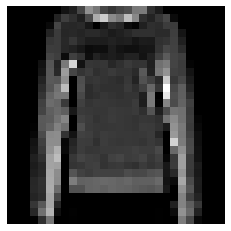

It is a  Pullover


In [ ]:
index=400
plt.imshow(X_train[400],cmap='gray')
plt.axis('off')
plt.show()
print('It is a ',y_names[y_train[index]])

###Baseline SVC

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
clf.fit(X_train_flatten, y_train_flatten.ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
clf.score(X_test_flatten, y_test_flatten)

0.8333

###SVC with random 2000 data point

In [74]:
model = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
model.fit(X_train_flatten[:2000], y_train_flatten[:2000].ravel())
print('Accuracy= {}'.format(model.score(X_test_flatten,y_test_flatten.ravel())))

Accuracy= 0.7234


In [ ]:
kmeans = KMeans(init='k-means++',n_clusters=2000, random_state=40)
X_items = kmeans.fit_transform(X_train_flatten)
representative_items_index = np.argmin(X_items, axis=0)
X_representative_items = X_train_flatten[representative_items_index]
y_representative_items = np.squeeze(y_train_flatten[representative_items_index]).astype('int32')

In [13]:
print(np.array(y_names)[y_representative_items])

['Ankle Boot' 'Sandal' 'T-shirt/top' ... 'Shirt' 'Bag' 'Sandal']


###SVC after preprocessing with 40% of original data points which are images nearest to centroids

In [24]:
clf1 = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
clf1.fit(X_representative_items, y_representative_items)
print('Accuracy= ',clf1.score(X_test_flatten, y_test_flatten))

Accuracy=  0.7793


In [25]:
y_train_propagated = np.empty(len(X_train_flatten), dtype=np.int32)
for i in range(2000):
    y_train_propagated[kmeans.labels_==i] = y_representative_items[i]

###SVC after propagating cluster label to every point in that particular cluster

In [55]:
clf2 = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000,random_state=40)
clf2.fit(X_train_flatten, y_train_propagated)
print(clf2.score(X_test_flatten,y_test_flatten))

0.8052


###SVC after propagating representative images to nearest 20% of the points to the centroids




In [132]:
X_cluster = X_items[np.arange(len(X_train_flatten)), kmeans.labels_]
for i in range(2000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster[in_cluster]
    cutoff = np.percentile(cluster_dist,20)
    above_cutoff = (X_cluster > cutoff)
    X_cluster[in_cluster & above_cutoff] = -1

In [133]:
partially_propagated = (X_cluster!= -1)
X_train_partially_propagated = X_train_flatten[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [134]:
clf3 = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000,random_state=40)
clf3.fit(X_train_partially_propagated, y_train_partially_propagated)
print(clf3.score(X_test_flatten,y_test_flatten))

0.7907
